# [House Prices Regression](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)
Here we try to predict the final price of residential homes in Iowa based on [Ames Housing Dataset](http://www.amstat.org/publications/jse/v19n3/decock.pdf) which describe almost every aspect these homes using 79 variables. 



In [444]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scipy.stats as st
from scipy.stats import skew
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, Ridge, Lasso
from sklearn.metrics import mean_squared_error

In [302]:
test = pd.read_csv('./data/test.csv', index_col=0)
train = pd.read_csv('./data/train.csv', index_col=0)
test.shape, train.shape

((1459, 79), (1460, 80))

We have 79 columns to predict in train plus 1 is the final SalePrice in train and 1460 such records of each house. Lets explore our data sets. 

In [303]:
print ("Numerical {1}  : {0}\n".format(train._get_numeric_data().columns.tolist(), len(train._get_numeric_data().columns) ))
print ("Categorical {1}  : {0}".format(list(set(train.columns.tolist()) - set(train._get_numeric_data().columns.tolist())),
                                  train.shape[1] -  len(train._get_numeric_data().columns) ))


Numerical 37  : ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']

Categorical 43  : ['SaleType', 'MiscFeature', 'KitchenQual', 'HeatingQC', 'Electrical', 'PoolQC', 'CentralAir', 'RoofMatl', 'HouseStyle', 'LotConfig', 'Neighborhood', 'Functional', 'LotShape', 'GarageFinish', 'PavedDrive', 'BsmtExposure', 'Condition2', 'GarageCond', 'Fence', 'BsmtQual', 'BsmtCond', 'Alley', 'GarageType', 'ExterQual', 'Exterior2nd', 'Street', 'MSZoning', 'SaleCondition', 'GarageQual', 'MasVnrType', 'Heating', 'Exterior1st', 'ExterCond', 'Foundation'

There are 37 numerical and 43 categorical features. Some numerical features(like MSSubClass) have numerical values corresponding to categories that means they are categorical. Some of the categorical features are ordinal in nature and can be mapped into numbers. Also lets check null values in our data. 

In [304]:
train.info(), test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-null object
Exterior2nd      1460 non-

(None, None)

As we see there are a null values in both test and train and some fields like Alley, PoolQC, Fence, MiscFeature have more than 50% null values. First lets try to fill up our NA values and then we will see how our features correlate. 

In [305]:
print ( "No of null columns in train : {0}\nNull columns : \n{1}".
       format(train.isnull().sum()[train.isnull().sum()>0].shape[0], train.isnull().sum()[train.isnull().sum()>0]))
print ( "No of null columns in test : {0}\nNull columns : \n{1}".
       format(test.isnull().sum()[test.isnull().sum()>0].shape[0], test.isnull().sum()[test.isnull().sum()>0]))

No of null columns in train : 19
Null columns : 
LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64
No of null columns in test : 33
Null columns : 
MSZoning           4
LotFrontage      227
Alley           1352
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        16
MasVnrArea        15
BsmtQual          44
BsmtCond          45
BsmtExposure      44
BsmtFinType1      42
BsmtFinSF1         1
BsmtFinType2      42
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu      730
GarageType        76
GarageYr

There are 19 null columns in train and 33 in test. There are 2 scenarios
1. Whether Nan value means no data(in this case we use mean/mode/median to fill Nan values)
2. Or Nan values imply that the particular feature is missing.(Here we just create a separate category for missing feature)

We decide whether it is case 1 or 2 by looking at the data description and analysing null values. Also there are few features which have almost all Nan values. For these features we will check whether they need to be considered in predicting house prices based on their correlation with SalePrice.

In [306]:
# Alley : both train and test, Nan means Alley not present, impute by 'NA'
train.Alley, test.Alley = (df.Alley.fillna('NA') for df in [train, test])

In [307]:
# MasVnrArea and MasVnrType
print (train.MasVnrType.isnull().sum(), train.MasVnrArea.isnull().sum())
print (test.MasVnrType.isnull().sum(), test.MasVnrArea.isnull().sum())
print ("train.masVnrArea : \n{0}\n".format(train.MasVnrArea.describe()))
print ("test.masVnrArea : \n{0}\n".format(test.MasVnrArea.describe()))
print ("59% of train.MasVnrArea : {0}".format(train.MasVnrArea.quantile(q=0.59)))
print ("60% of test.MasVnrArea : {0}\n".format(test.MasVnrArea.quantile(q=0.6)))
print ("Most frequent category in train.MasVnrType : {0}".format(train.MasVnrType.value_counts().index[0]))
print ("Most frequent category in test.MasVnrType : {0}\n".format(test.MasVnrType.value_counts().index[0]))
print ("Mean MasVnrArea of most frequent category of train.MasVnrType : {0}"
       .format(train.loc[train.MasVnrType==train.MasVnrType.value_counts().index[0]].MasVnrArea.mean() ) )
print ("Mean MasVnrArea of most frequent category of test.MasVnrType : {0}\n"
       .format(test.loc[test.MasVnrType==test.MasVnrType.value_counts().index[0]].MasVnrArea.mean() ) )

8 8
16 15
train.masVnrArea : 
count    1452.000000
mean      103.685262
std       181.066207
min         0.000000
25%         0.000000
50%         0.000000
75%       166.000000
max      1600.000000
Name: MasVnrArea, dtype: float64

test.masVnrArea : 
count    1444.000000
mean      100.709141
std       177.625900
min         0.000000
25%         0.000000
50%         0.000000
75%       164.000000
max      1290.000000
Name: MasVnrArea, dtype: float64

59% of train.MasVnrArea : 0.0
60% of test.MasVnrArea : 0.0

Most frequent category in train.MasVnrType : None
Most frequent category in test.MasVnrType : None

Mean MasVnrArea of most frequent category of train.MasVnrType : 1.0949074074074074
Mean MasVnrArea of most frequent category of test.MasVnrType : 0.32574031890660593



Here we see that 8 values of MasVnrType and 8 values of MasVnrArea are Nan in training data while 16 values of MasVnrType and 15 of MasVnrArea are Nan in test data. There can be many ways of imputing these values. 
1. As we see close 60% of MasVnr in both train and test is 0, but due to few very high values the mean reaches close to 100. 
2. 'None' is the most frequent category of MasVnrType in both train and test, so we can replace the Nan values 'None'.
3. Also the mean of MasVnrArea of 'None' category(most frequent) is vastly different than overall mean of MasVnrArea in both train and test so instead of imputing Nan values of MasVnrArea by overall mean of MasVnrArea, we will impute by mean of MasVnrArea of most frequent category ie 'None'.(It also makes sense as we are imputing MasVnrType by 'None') 

In [308]:
train.MasVnrType, test.MasVnrType = (df.MasVnrType.fillna(df.MasVnrType.mode()[0]) for df in [train, test])
train.MasVnrArea, test.MasVnrArea = (df.MasVnrArea.fillna( 
    df.loc[df.MasVnrType==df.MasVnrType.mode()[0]].MasVnrArea.mean() 
     ) for df in [train, test])

In [309]:
# Basement related features, replace by mean(if numerical) or mode(if categorical)

train.BsmtQual, test.BsmtQual = (df.BsmtQual.fillna(df.BsmtQual.mode()[0]) for df in [train,test])
train.BsmtCond, test.BsmtCond = (df.BsmtCond.fillna(df.BsmtCond.mode()[0]) for df in [train,test])
train.BsmtExposure, test.BsmtExposure = (df.BsmtExposure.fillna(df.BsmtExposure.mode()[0]) for df in [train,test])
train.BsmtFinType1, test.BsmtFinType1 = (df.BsmtFinType1.fillna(df.BsmtFinType1.mode()[0]) for df in [train,test])
train.BsmtFinType2, test.BsmtFinType2 = (df.BsmtFinType2.fillna(df.BsmtFinType2.mode()[0]) for df in [train,test])

test.BsmtFinSF1 = test.BsmtFinSF1.fillna(test.BsmtFinSF1.mean())
test.BsmtFinSF2 = test.BsmtFinSF2.fillna(test.BsmtFinSF2.mean())
test.BsmtUnfSF = test.BsmtUnfSF.fillna(test.BsmtUnfSF.mean())
test.TotalBsmtSF = test.TotalBsmtSF.fillna(test.TotalBsmtSF.mean())
test.BsmtHalfBath = test.BsmtHalfBath.fillna(test.BsmtHalfBath.mean())
test.BsmtFullBath = test.BsmtFullBath.fillna(test.BsmtFullBath.mean())

In [310]:
# train.Electrical has 1 Nan value, replace by  mode
train.Electrical = train.Electrical.fillna(train.Electrical.mode()[0])

# Nan in FireplaceQu correponds to no Fireplace, replace Nan by 'NA'
train.FireplaceQu, test.FireplaceQu = (df.FireplaceQu.fillna('NA') for df in [train,test])

In [311]:
# Garage related features

print (train.GarageType.isnull().sum(), test.GarageType.isnull().sum()) # no of null values of Garage Type
print (train.loc[train.GarageArea==0].shape[0], test.loc[test.GarageArea==0].shape[0]) # No of records where GarageArea is 0
print (train.loc[train.GarageArea==0 & train.GarageType.isnull()].shape[0], 
       test.loc[test.GarageArea==0 & test.GarageType.isnull()].shape[0]
      ) # No of records where both GarageType is null and GarageArea =0



81 76
81 76
81 76


These numbers show that NaN values of GarageType means absence of Garage and can be replaced by 'NA'. Lets analyse other features related to Garage. 

In [312]:
# For each column in train we find the no of null values, and number of null values when GarageTye is Nan. 
print ("Train.csv : ")
print (train.GarageYrBlt.isnull().sum(), train.loc[train.GarageType.isnull() & train.GarageYrBlt.isnull()].shape[0])
print (train.GarageFinish.isnull().sum(),train.loc[train.GarageType.isnull() & train.GarageFinish.isnull()].shape[0])
print (train.GarageQual.isnull().sum(), train.loc[train.GarageType.isnull() & train.GarageQual.isnull()].shape[0])
print (train.GarageCond.isnull().sum(), train.loc[train.GarageType.isnull() & train.GarageCond.isnull()].shape[0])

# For each column in train we find the no of null values, and number of null values when GarageTye is Nan. 
print ("\nTest.csv : ")
print (test.GarageYrBlt.isnull().sum(), test.loc[test.GarageType.isnull() & test.GarageYrBlt.isnull()].shape[0])
print (test.GarageFinish.isnull().sum(),test.loc[test.GarageType.isnull() & test.GarageFinish.isnull()].shape[0])
print (test.GarageQual.isnull().sum(), test.loc[test.GarageType.isnull() & test.GarageQual.isnull()].shape[0])
print (test.GarageCond.isnull().sum(), test.loc[test.GarageType.isnull() & test.GarageCond.isnull()].shape[0])



Train.csv : 
81 81
81 81
81 81
81 81

Test.csv : 
78 76
78 76
78 76
78 76


In train the Garage related columns are null only when GarageType is Null, so can be replace by NA. In test there are 2 records where GarageTyep is not Nan but the 4 columns related to Garage are Nan. These can be replace by mean/mode. Now the question is how to replace Nan values in GarageYrBlt when there is no Garage ie GarageType is Nan. So we will convert GarageYrBlt to categorical(ordinal) variable by binning it and replace Nan by a separate category. 

In [313]:
# First we change the 2 other records to mode. They are in test not in train. 
ind = test.loc[test.GarageType.notnull() & test.GarageQual.isnull()].index
test.loc[ind, 'GarageQual'] = test.GarageQual.mode()[0]
ind = test.loc[test.GarageType.notnull() & test.GarageCond.isnull()].index
test.loc[ind, 'GarageCond'] = test.GarageCond.mode()[0]
ind = test.loc[test.GarageType.notnull() & test.GarageFinish.isnull()].index
test.loc[ind, 'GarageFinish'] = test.GarageFinish.mode()[0]
ind = test.loc[test.GarageType.notnull() & test.GarageYrBlt.isnull()].index
test.loc[ind, 'GarageYrBlt'] = test.GarageYrBlt.median()

# Change the rest of the values to be 'NA' in both train and test

train.GarageType, test.GarageType = (df.GarageType.fillna('NA') for df in [train,test])
train.GarageFinish, test.GarageFinish = (df.GarageFinish.fillna('NA') for df in [train,test])
train.GarageCond, test.GarageCond = (df.GarageCond.fillna('NA') for df in [train,test])
train.GarageQual, test.GarageQual = (df.GarageQual.fillna('NA') for df in [train,test])

In [314]:
train.GarageYrBlt, train_bins = pd.cut(train.GarageYrBlt, 10, labels=np.arange(1,11.0), retbins=True)
train_bins

array([ 1899.89,  1911.  ,  1922.  ,  1933.  ,  1944.  ,  1955.  ,
        1966.  ,  1977.  ,  1988.  ,  1999.  ,  2010.  ])

Now according to the bins that we got from train, we categorise our test data. Remember that we categorise out test.GarageYrBlt using bins from train data. 


In [315]:
test.loc[test.GarageYrBlt<=train_bins[1], ['GarageYrBlt']] = 1
test.loc[(test.GarageYrBlt<=train_bins[2]) & (test.GarageYrBlt>train_bins[1]), ['GarageYrBlt']] = 2
test.loc[(test.GarageYrBlt<=train_bins[3]) & (test.GarageYrBlt>train_bins[2]), ['GarageYrBlt']] = 3
test.loc[(test.GarageYrBlt<=train_bins[4]) & (test.GarageYrBlt>train_bins[3]), ['GarageYrBlt']] = 4
test.loc[(test.GarageYrBlt<=train_bins[5]) & (test.GarageYrBlt>train_bins[4]), ['GarageYrBlt']] = 5
test.loc[(test.GarageYrBlt<=train_bins[6]) & (test.GarageYrBlt>train_bins[5]), ['GarageYrBlt']] = 6
test.loc[(test.GarageYrBlt<=train_bins[7]) & (test.GarageYrBlt>train_bins[6]), ['GarageYrBlt']] = 7
test.loc[(test.GarageYrBlt<=train_bins[8]) & (test.GarageYrBlt>train_bins[7]), ['GarageYrBlt']] = 8
test.loc[(test.GarageYrBlt<=train_bins[9]) & (test.GarageYrBlt>train_bins[8]), ['GarageYrBlt']] = 9
test.loc[(test.GarageYrBlt>train_bins[9]), ['GarageYrBlt']] = 10

Now we can replace the Nan values in train.GarageYrBlt and test.GarageYrBlt by 0 which acts as another category. 

In [316]:
test.GarageYrBlt = test.GarageYrBlt.astype('category')
train.GarageYrBlt, test.GarageYrBlt = (df.GarageYrBlt.cat.add_categories(0) for df in [train, test])
train.GarageYrBlt, test.GarageYrBlt = (df.GarageYrBlt.fillna(0) for df in [train,test])

There are still 2 Nan, one in each test.GarageArea and test.GarageCars. For GarageArea we replace by mean and for GarageCars we replace by median(as mean would be float and doesn't match with the description of GarageCars). 

In [317]:
test.GarageArea = test.GarageArea.fillna(test.GarageArea.mean())
test.GarageCars = test.GarageCars.fillna(test.GarageCars.median())

In [318]:
# Nan in Fence means No Fence, replace by 'NA'
train.Fence, test.Fence = (df.Fence.fillna('NA') for df in [train,test])

In [319]:
print (train.MiscFeature.isnull().sum(), test.MiscFeature.isnull().sum())
print (train.loc[train.MiscVal==0].shape[0], test.loc[test.MiscVal==0].shape[0])
print (train.loc[(train.MiscFeature.isnull()) & (train.MiscVal==0)].shape[0], 
       test.loc[(test.MiscFeature.isnull()) & (test.MiscVal==0)].shape[0])
# train.loc[(train.MiscFeature.notnull()) & (train.MiscVal==0), ['MiscFeature', 'MiscVal']]
# test.loc[(test.MiscFeature.notnull()) | (test.MiscVal!=0), ['MiscFeature', 'MiscVal']].shape
test.MiscFeature.value_counts()

1406 1408
1408 1408
1406 1407


Shed    46
Gar2     3
Othr     2
Name: MiscFeature, dtype: int64

1. Here in 'train' there are 1406 records with MiscVal=0 and MiscFeature=Nan, so we can replace Nan in MiscFeature by 'NA'.
2. In 'test' there are 1407 records where MiscVal=0 and MiscFeature=Nan, so here also we will replace Nan in MiscFeature by 'NA'.
3. There is one other record in 'test' where MiscVal>0 and MiscFeature is null. For this Nan we impute it by mode of test.MiscFeature.


In [320]:
test.loc[(test.MiscVal>0) & (test.MiscFeature.isnull()), ['MiscFeature']] = test.MiscFeature.mode()[0]
train.MiscFeature, test.MiscFeature = (df.MiscFeature.fillna('NA') for df in [train, test])

In [321]:
# SaleType : fill by mode
test.SaleType = test.SaleType.fillna(test.SaleType.mode()[0])

# Functional : Replace by mode
test.Functional = test.Functional.fillna(test.Functional.mode()[0])

# KitchenQual  Replace by mode
test.KitchenQual = test.KitchenQual.fillna(test.KitchenQual.mode()[0])

#Exterior1st, Exterior2nd : replace by mode
test.Exterior1st = test.Exterior1st.fillna(test.Exterior1st.mode()[0])
test.Exterior2nd = test.Exterior2nd.fillna(test.Exterior2nd.mode()[0])

#Utilities : replace by mode
test.Utilities = test.Utilities.fillna(test.Utilities.mode()[0])

In [322]:
#PoolQc
print (train.PoolQC.isnull().sum(), test.PoolQC.isnull().sum())
print (train.loc[train.PoolArea==0].shape[0], test.loc[test.PoolArea==0].shape[0])
print (train.loc[train.PoolArea==0 & train.PoolQC.isnull()].shape[0], test.loc[test.PoolArea==0 & test.PoolQC.isnull()].shape[0])
print (test.loc[(test.PoolArea>0) & (test.PoolQC.isnull()), ['PoolQC', 'PoolArea']])


1453 1456
1453 1453
1453 1453
     PoolQC  PoolArea
Id                   
2421    NaN       368
2504    NaN       444
2600    NaN       561


From the above operations we see that there are 1453 Nan values of PoolQc in train and all of those 1453 records have PoolArea=0. So for these records we can fill nan values of PoolQc by 'NA'. There are 3 extra records for which PoolQc is null in test, for which we can use mode. 

In [323]:
test.loc[test.PoolArea>0 & test.PoolQC.isnull(), ['PoolQC']] = test.PoolQC.mode()[0]
train.PoolQC, test.PoolQC = (df.PoolQC.fillna('NA') for df in [train, test])

#### LotFrontage

In [324]:
print ("No of null values in train.LotFrontage : {0}".format(train.LotFrontage.isnull().sum()))
print ("No of null values in test.LotFrontage : {0}".format(test.LotFrontage.isnull().sum()))

No of null values in train.LotFrontage : 259
No of null values in test.LotFrontage : 227


There are 259 null values in train.LotFrontage and 257 null values in test.LotFrontage. Let's look at their distribution. 

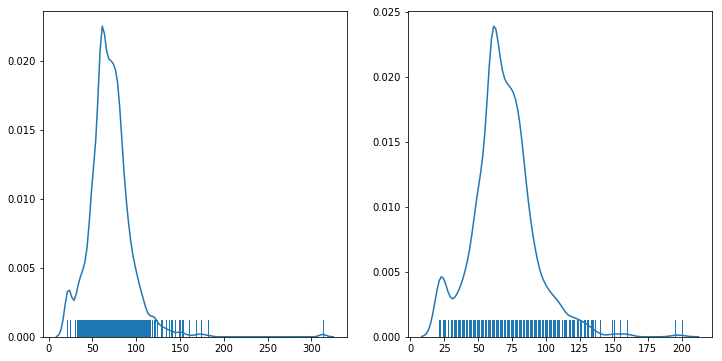

In [325]:
_,axes = plt.subplots(1,2, figsize=(12,6))
sns.distplot(train.loc[train.LotFrontage.notnull(),['LotFrontage']], rug=True, hist=False, ax=axes[0])
sns.distplot(test.loc[test.LotFrontage.notnull(),['LotFrontage']], rug=True, hist=False, ax=axes[1])

In [326]:
print (train.LotFrontage.describe(), '\n')
print (test.LotFrontage.describe())

count    1201.000000
mean       70.049958
std        24.284752
min        21.000000
25%        59.000000
50%        69.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64 

count    1232.000000
mean       68.580357
std        22.376841
min        21.000000
25%        58.000000
50%        67.000000
75%        80.000000
max       200.000000
Name: LotFrontage, dtype: float64


The distribution plot of LotFrontage shows presence of 1 or 2 outliers in both test and train. So our mean might be slightly biased towards higher values of LotFrontage. There can be 3 ways of imputing values of LotFrontage : 
1. Mean
2. Median 
3. Finding the features most correlated with LotFrontage and then predicting LotFrontage based on those features. 

For now we stick with the mean. 

In [327]:
train.LotFrontage, test.LotFrontage = (df.LotFrontage.fillna(df.LotFrontage.mean()) for df in [train, test])

In [328]:
# MSZoning : Nan in test, replace by mode
test.MSZoning = test.MSZoning.fillna(test.MSZoning.mode()[0])

In [329]:
train.isnull().sum().sum(), test.isnull().sum().sum()

(0, 0)

Till now we have taken care of all Nan values in train and test. 

In [330]:
train._get_numeric_data().columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In the numerical features listed above there are a couple of features which are should have been categorical. 
1. MSSubClass : It identifies the type of dwelling, which should be categorical but the categories are represented by numbers. 
2. MoSold : The month sold also should be categorical since it can take only fized numbers

In [331]:
ms_subclass_dict = {20:'MSC_20', 30:'MSC_30', 40:'MSC_40', 45:'MSC_45', 50:'MSC_50', 60:'MSC_60', 70:'MSC_70', 75:'MSC_75'
                    , 80:'MSC_80', 85:'MSC_85', 90:'MSC_90', 120:'MSC_120', 150:'MSC_150', 160:'MSC_160', 180:'MSC_180'
                    , 190:'MSC_190'
                   }

train.MSSubClass = train.MSSubClass.map(ms_subclass_dict)
test.MSSubClass = test.MSSubClass.map(ms_subclass_dict)

In [332]:
mo_sold_dict = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov',12:'Dec'}
train.MoSold = train.MoSold.map(mo_sold_dict)
test.MoSold = test.MoSold.map(mo_sold_dict)

### Mapping ordinal categories
There are various **'Qual', 'Cond'** named features which are ordinal features. By converting them to numerical we will be be able to quantify the correlation between these features and others.  

In [333]:
main_dict = {'NA':0, 'Po':1, 'No':1, 'Unf':1, 'Fa':2, 'Mn':2, 'Av':3, 'TA':3, 'RFn':3, 'Gd':4, 'Ex':5, 'Fin':5}
bsmt_finish_dict = {'NA':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6}

train.ExterQual, test.ExterQual = (df.ExterQual.map(main_dict) for df in [train, test])
train.ExterCond, test.ExterCond = (df.ExterCond.map(main_dict) for df in [train, test])
train.BsmtQual, test.BsmtQual = (df.BsmtQual.map(main_dict) for df in [train, test])
train.BsmtCond, test.BsmtCond = (df.BsmtCond.map(main_dict) for df in [train, test])
train.BsmtExposure, test.BsmtExposure = (df.BsmtExposure.map(main_dict) for df in [train, test])
train.HeatingQC, test.HeatingQC = (df.HeatingQC.map(main_dict) for df in [train, test])
train.KitchenQual, test.KitchenQual = (df.KitchenQual.map(main_dict) for df in [train, test])
train.FireplaceQu, test.FireplaceQu = (df.FireplaceQu.map(main_dict) for df in [train, test])
train.GarageFinish, test.GarageFinish = (df.GarageFinish.map(main_dict) for df in [train, test])
train.GarageCond, test.GarageCond = (df.GarageCond.map(main_dict) for df in [train, test])
train.GarageQual, test.GarageQual = (df.GarageQual.map(main_dict) for df in [train, test])
train.PoolQC, test.PoolQC = (df.PoolQC.map(main_dict) for df in [train, test])

train.BsmtFinType1, test.BsmtFinType1 = (df.BsmtFinType1.map(bsmt_finish_dict) for df in [train, test])
train.BsmtFinType2, test.BsmtFinType2 = (df.BsmtFinType2.map(bsmt_finish_dict) for df in [train, test])

In [334]:
print ("Numerical {1}  : {0}\n".format(train._get_numeric_data().columns.tolist(), len(train._get_numeric_data().columns) ))
print ("Categorical {1}  : {0}".format(list(set(train.columns.tolist()) - set(train._get_numeric_data().columns.tolist())),
                                  train.shape[1] -  len(train._get_numeric_data().columns) ))


Numerical 48  : ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Fireplaces', 'FireplaceQu', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'MiscVal', 'YrSold', 'SalePrice']

Categorical 32  : ['SaleType', 'MiscFeature', 'Electrical', 'CentralAir', 'RoofMatl', 'HouseStyle', 'LotConfig', 'Neighborhood', 'Functional', 'LotShape', 'PavedDrive', 'Condition2', 'Fence', 'Alley', 'GarageType', 'MSSubClass', 'Exterior2nd', 'Street', 'MSZoning', 'SaleCondition', 'MasVnrType', 'Heating', 'MoSo

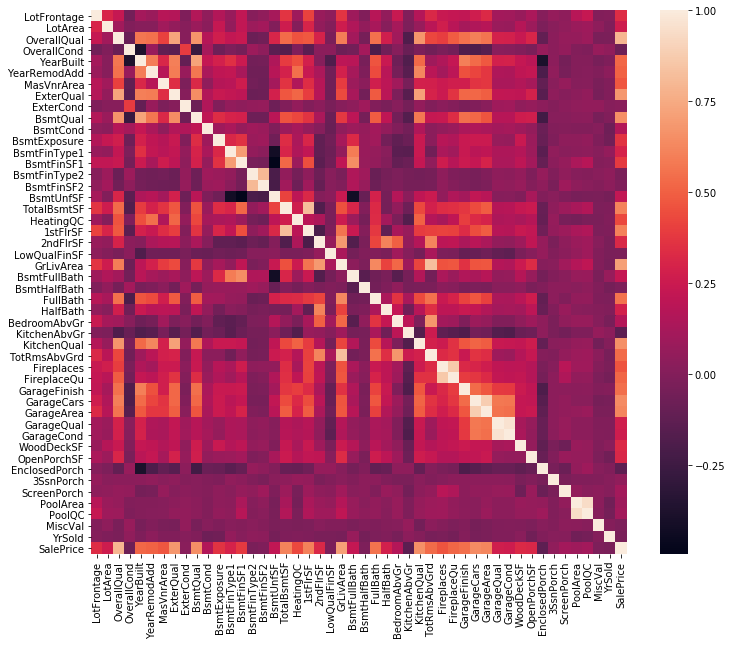

In [335]:
_, ax = plt.subplots(figsize=(12,10))
sns.heatmap(train[list(train._get_numeric_data().columns)].corr(), ax=ax)

Above heatmap shows correlations amongs all numerical features. By looking at the colors of squares we can see which of the variables are highly correlated. Just look for light colored squares. 
1. SalePrice is correlated with OverallQual, GrLivArea, ExterQual, BsmtQual, GarageCars, KitchenQual. 
2. GarageCars is highly correlated with GarageArea which makes as well. 
3. TotRmsAbvGrd is correlated with GrLivArea
4. TotalBsmtSF is correlated with 1stFlrSF

In [336]:
saleprice_corr=pd.DataFrame(index=list(train._get_numeric_data().columns), columns=['Correlation'])
for feature in list(saleprice_corr.index) :
    saleprice_corr.loc[feature] = train.SalePrice.corr(train[feature])
saleprice_corr = saleprice_corr.sort_values(by='Correlation', ascending=False)
saleprice_corr.head(10)

,Correlation
SalePrice,1
OverallQual,0.790982
GrLivArea,0.708624
ExterQual,0.682639
KitchenQual,0.6596
BsmtQual,0.650138
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581
1stFlrSF,0.605852


Above we saw the 10 features SalePrice is most correlated with. It also shows the presence of collinear feature loike GarageArea and GarageCars, TotalBsmtSF and 1stFlrSF. 
### Analysing SalePrice

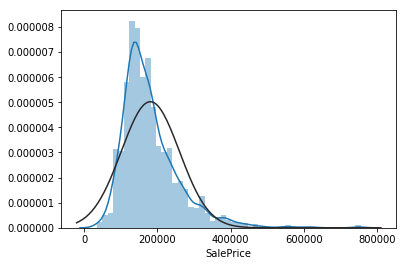

In [337]:
sns.distplot(train.SalePrice, fit=st.norm)



Above is a distribution of SalePrice which shows a deviation from normal with a distinct positive skew. To make it close to normal will take its log transform. Also for other predictor variables we will check their skewness and log transform them if skewed above a threshold. Also taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally. Taking Log transform makes linear regression perform better - since linear regression is sensitive to outliers. Note that if I use a tree-based model I wouldn't need to transform the variables.

We will log transform that but first lets analyse our numerical variables that are highly correlated with SalePrice.  

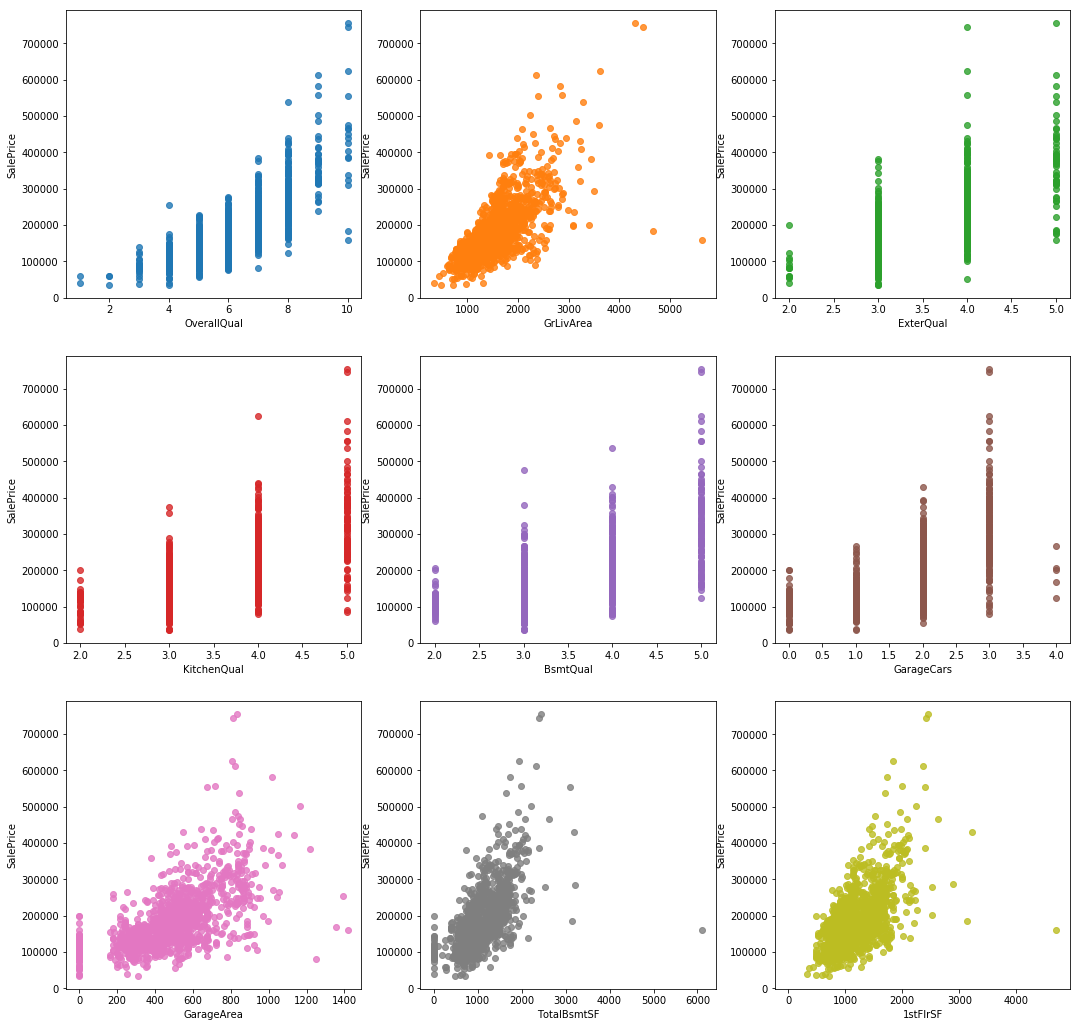

In [338]:
feat = list(saleprice_corr.index)[:10]
_,axes = plt.subplots(3,3, figsize=(18,18))
for i in range(len(feat)-1):
   _ = sns.regplot(x=feat[i+1], y='SalePrice', data=train, fit_reg=False, ax=axes[int(i/3)][i%3])


Few interesting observations can be made from above plots : 
1. SalePrice which has the highest correlation with OverQual, increases as Overall quality increases.
2. In GrLivArea vs SalePrice we see presence of 2 outliers with GrLivArea. Even the author of the dataset recommends to treat any houses with more than 4000 sq ft as outliers and remove. So at least we can safely remove the 2 outliers. 
3. Plots also convey presence of non-linear relationship for which we can either introduce higher degree of features or choose non linear approaches while modelling. 

For ordinal variables there is a positive relationship between SalePrice and the feature. For more detailed analysis we will need boxplots or violinplots. 
### Analysing Categorical variables : 
To find the importance of categorical variables we check with ANOVA test.

In [339]:
def anova(frame):
    cat_features = train.dtypes[train.dtypes=='object'].index
    anv = pd.DataFrame()
    anv['feature'] = cat_features    
    pvals=[]
    for feature in cat_features:
        samples=[]
        for c in frame[feature].unique():
            s = frame[frame[feature]==c]['SalePrice'].values
            samples.append(s)
        pval = st.f_oneway(*samples)[1]
        pvals.append(pval)
    anv['pval'] = pvals
    return anv.sort_values('pval')

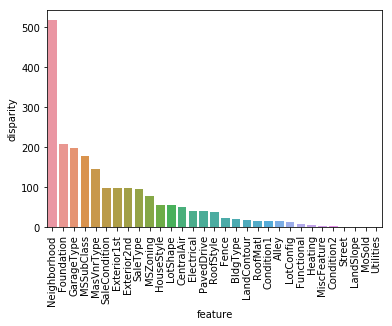

In [340]:
a = anova(train)
a['disparity'] = np.log(1./a['pval'].values)
sns.barplot(data=a, x='feature', y='disparity')
x=plt.xticks(rotation=90)

Features 'Neighbourhood', 'GarageType' and 'Foundation' seem to most significant whereas 'LandSold', 'MoSold', 'utilities' and 'MSSubclass' are least significant. 

Now lets log transform our data and remove outliers. 

In [341]:
train = train.loc[train.GrLivArea<4000]

In [342]:

train["SalePrice"] = np.log1p(train["SalePrice"])
# combined_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'], test.loc[:,'MSSubClass':'SaleCondition']))
numeric_feats = test.dtypes[test.dtypes != "object"].index
skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index
train[skewed_feats], test[skewed_feats] = (np.log1p(df[skewed_feats]) for df in [train, test] )

And before I forget lets dummify our categorical variables. Here I am concatenating both train and test before dummifying as certain categorical features in train might have levels that aren't present in test or vice-versa. 

In [385]:
train_without_saleprice = train.drop(['SalePrice'], axis=1)
all_data = pd.concat([train_without_saleprice, test])
all_data['GarageYrBlt'] = all_data['GarageYrBlt'].astype('category')
all_data_dummy = pd.get_dummies(all_data)

In [404]:
train_dummy = all_data_dummy.iloc[:train.shape[0],:]
test_dummy = all_data_dummy.iloc[train.shape[0]:,:]
train_dummy['SalePrice'] = train['SalePrice']

/home/akshay/Data/skl-v/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


## Modelling
Lets try various regression models with and without regularization. 

In [407]:
np.random.seed(1)
X = train_dummy.drop(['SalePrice'], axis=1)
y = train_dummy['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)


In [408]:
# Linear regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

print ("Train MSE : {0}".format(rmse_train))
print ("Test MSE : {0}".format(rmse_test))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Train MSE : 0.07856973358229935
Test MSE : 0.148620710542504


In [449]:
# Regularization with L2 penalty : Ridge regression
alphas = [0.1, 1,2, 3,4, 5, 6, 7, 8, 10, 20]
rcv = RidgeCV(alphas, cv=10)
rcv.fit(X_train, y_train)
y_pred_train = rcv.predict(X_train)
y_pred_test = rcv.predict(X_test)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

print ("Alpha(Shrinkage parameter) : {0}".format(rcv.alpha_))
print ("Train MSE : {0}".format(rmse_train))
print ("Test MSE : {0}".format(rmse_test))

RidgeCV(alphas=[0.1, 1, 2, 3, 4, 5, 6, 7, 8, 10, 20], cv=10,
    fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
    store_cv_values=False)

Alpha(Shrinkage parameter) : 6
Train MSE : 0.08618928672757828
Test MSE : 0.12701601610838062


In [459]:
# Linear regression with L1 regularization : Lasso
alphas = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]
lcv = LassoCV(cv=10, alphas=alphas)
lcv.fit(X_train, y_train)

y_pred_train = lcv.predict(X_train)
y_pred_test = lcv.predict(X_test)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

print ("Alpha(Shrinkage parameter) : {0}".format(lcv.alpha_))
print ("Train MSE : {0}".format(rmse_train))
print ("Test MSE : {0}".format(rmse_test))

LassoCV(alphas=[0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1], copy_X=True,
    cv=10, eps=0.001, fit_intercept=True, max_iter=1000, n_alphas=100,
    n_jobs=1, normalize=False, positive=False, precompute='auto',
    random_state=None, selection='cyclic', tol=0.0001, verbose=False)

Alpha(Shrinkage parameter) : 0.0005
Train MSE : 0.0906380319165547
Test MSE : 0.1251872863806182


Always remember to train your final models on full data. 

In [474]:
lr.fit(X,y)
y_pred = lr.predict(test_dummy)
y_pred = np.expm1(y_pred)
df_lr = pd.DataFrame(y_pred, index=test.index, columns=['SalePrice'])
df_lr.to_csv('./lr.csv')

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [476]:
rr = Ridge(alpha=6)
rr.fit(X,y)
y_pred = rr.predict(test_dummy)
y_pred = np.expm1(y_pred)
df_rr = pd.DataFrame(y_pred, index=test.index, columns=['SalePrice'])
df_rr.to_csv('./rr.csv')

Ridge(alpha=6, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [477]:
lasso = Lasso(alpha=0.0005)
lasso.fit(X,y)
y_pred = lasso.predict(test_dummy)
y_pred = np.expm1(y_pred)
df_lasso = pd.DataFrame(y_pred, index=test.index, columns=['SalePrice'])
df_lasso.to_csv('./lasso.csv')

Lasso(alpha=0.0005, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)